### 1. Data Exploration, Preprocessing and visualization

Total missing values: 0
Total outliers detected: 3875


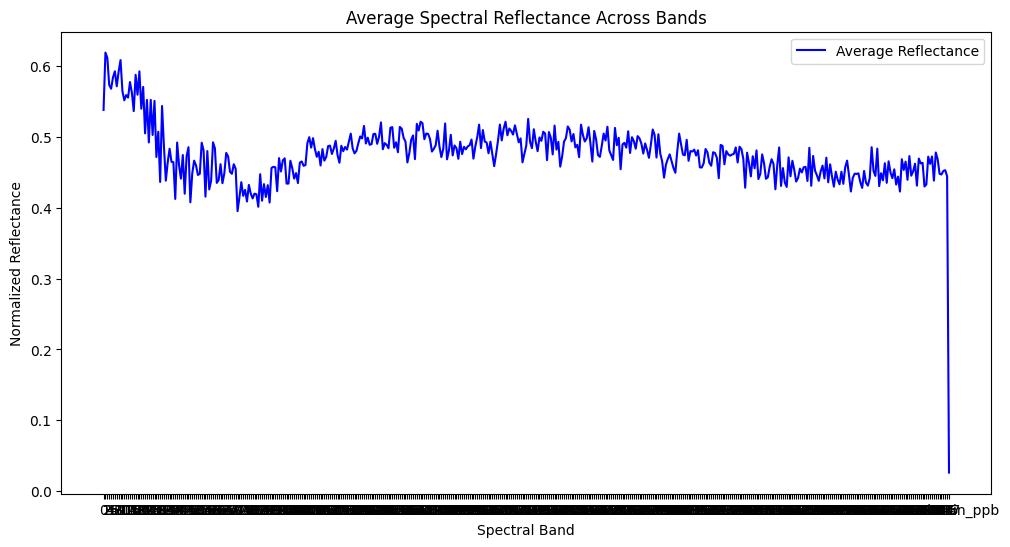

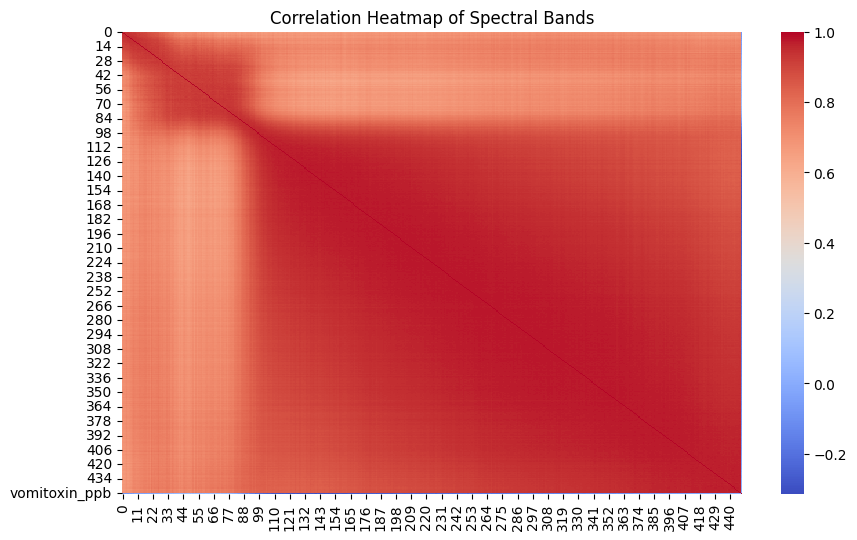

In [19]:
## Step 1: Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Step 2: Load the Dataset
file_path = "TASK-ML-INTERN.csv"  # Update path if needed
df = pd.read_csv(file_path)

## Step 3: Inspect Missing Values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

# Fill missing values with column mean
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

## Step 4: Detect Outliers (Using IQR Method)
Q1 = df.iloc[:, 1:].quantile(0.25)
Q3 = df.iloc[:, 1:].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df.iloc[:, 1:] < (Q1 - 1.5 * IQR)) | (df.iloc[:, 1:] > (Q3 + 1.5 * IQR))).sum().sum()
print(f"Total outliers detected: {outliers}")

## Step 5: Normalize or Standardize Data
scaler = MinMaxScaler()  # Change to StandardScaler() if needed
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

## Step 6: Data Visualization
# Line Plot: Average Reflectance Across Spectral Bands
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[:, 1:].mean(), label="Average Reflectance", color='blue')
plt.xlabel("Spectral Band")
plt.ylabel("Normalized Reflectance")
plt.title("Average Spectral Reflectance Across Bands")
plt.legend()
plt.show()

# Heatmap: Sample-to-Sample Comparison
plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:, 1:].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Spectral Bands")
plt.show()

## Step 7: Remove Duplicates
df.drop_duplicates(inplace=True)

### 2. Dimensionality Reduction : PCA, t-SNE and Visualization of Reduced data

Variance Explained by PCA Components: [9.99999992e-01 7.68962397e-09]


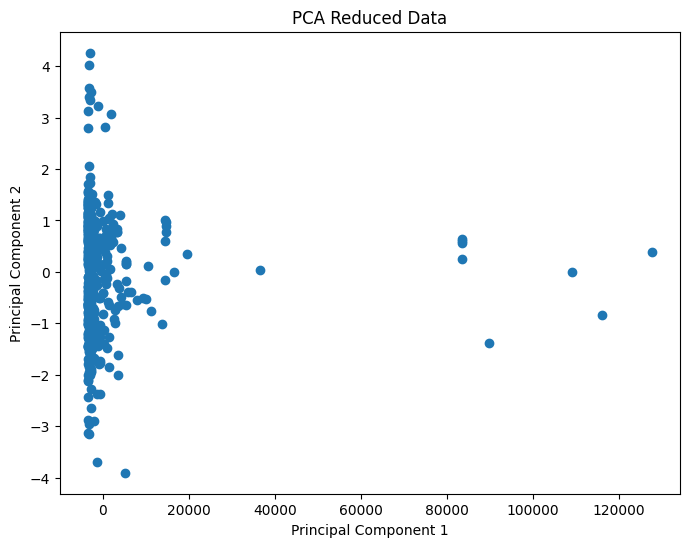

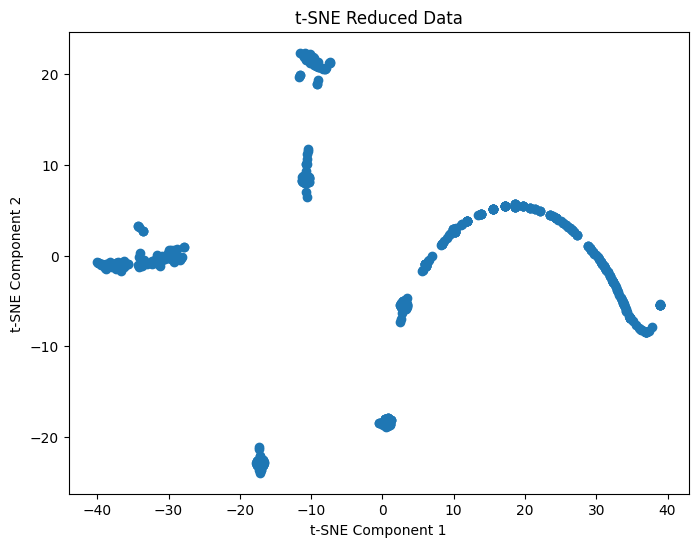

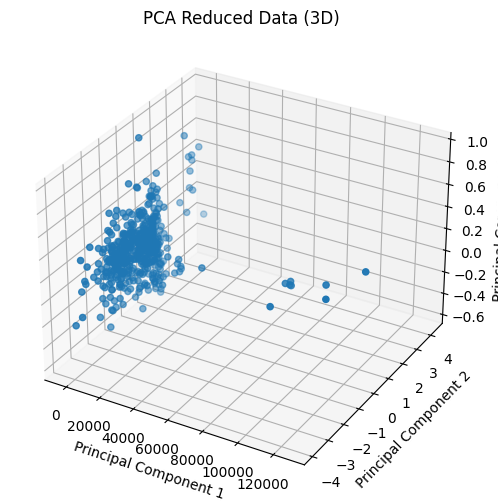

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load dataset (assuming it's preprocessed)
dataset = pd.read_csv('TASK-ML-INTERN.csv')

# Apply PCA
def apply_pca(data, n_components):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data, pca

# Apply t-SNE
def apply_tsne(data, n_components):
    tsne = TSNE(n_components=n_components, random_state=42)
    reduced_data_tsne = tsne.fit_transform(data)
    return reduced_data_tsne

# Main execution
n_components = 2  # Reduce to 2 dimensions for visualization

reduced_data_pca, pca = apply_pca(dataset.iloc[:, 1:], n_components)
print("Variance Explained by PCA Components:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1])
plt.title('PCA Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

reduced_data_tsne = apply_tsne(dataset.iloc[:, 1:], n_components)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1])
plt.title('t-SNE Reduced Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Optional 3D visualization
n_components_3d = 3
reduced_data_pca_3d, pca_3d = apply_pca(dataset.iloc[:, 1:], n_components_3d)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(reduced_data_pca_3d[:, 0], reduced_data_pca_3d[:, 1], reduced_data_pca_3d[:, 2])
ax.set_title('PCA Reduced Data (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

### 3. Model Training (CNN)
##### CNN is best for Hyperspectral Imaging data

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder

# Load dataset
dataset = pd.read_csv('TASK-ML-INTERN.csv')

# Inspect class distribution
def inspect_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts()
    print("Class Distribution:")
    print(class_counts)
    return class_counts

# Remove classes with fewer than 2 samples
def remove_sparse_classes(data, labels, min_samples=2):
    class_counts = pd.Series(labels).value_counts()
    sparse_classes = class_counts[class_counts < min_samples].index
    
    # Identify indices to keep
    keep_indices = ~pd.Series(labels).isin(sparse_classes)
    
    # Filter data and labels
    filtered_data = data[keep_indices]
    filtered_labels = labels[keep_indices]
    
    print(f"Removed classes: {sparse_classes}")
    return filtered_data, filtered_labels

# Split dataset into training and testing sets
def split_dataset(data, labels, test_size=0.01):  # Reduced test_size to 0.01
    try:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42, stratify=labels)
    except ValueError as e:
        print("Stratified split failed. Performing manual split.")
        
        # Manual Split: ensure each class has at least one sample in test set
        unique_classes = np.unique(labels)
        test_indices = []
        train_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            test_index = cls_indices[0]  # Take the first index for test
            train_indices_cls = cls_indices[1:]  # Remaining indices for training
            
            test_indices.append(test_index)
            train_indices.extend(train_indices_cls)
            
        X_train = data.iloc[train_indices]
        X_test = data.iloc[test_indices]
        y_train = labels[train_indices]
        y_test = labels[test_indices]
        
        print("Manual split complete.")
        return X_train, X_test, y_train, y_test
        
    return X_train, X_test, y_train, y_test

# Reshape data for CNN input
def reshape_data(data):
    reshaped_data = data.values.reshape(-1, data.shape[1], 1)
    return reshaped_data

# Define CNN model architecture
def create_cnn_model(input_shape, optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation=activation, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(set(y_train)), activation='softmax'))  # Output layer for classification
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluate the best model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)  # Suppress Keras output
    print(f"Test Accuracy: {accuracy:.2f}")

# Main execution
labels = dataset['hsi_id']
data = dataset.drop('hsi_id', axis=1)

# Inspect class distribution
inspect_class_distribution(labels)

# Encode labels if they are not numerical
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Remove sparse classes
data, labels = remove_sparse_classes(data, labels)

# Re-encode labels after removing sparse classes
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(data, labels)

# Reshape data for CNN input
X_train_reshaped = reshape_data(X_train)
X_test_reshaped = reshape_data(X_test)

# Determine the input shape
input_shape = (X_train_reshaped.shape[1], 1)

# Create CNN model with fixed hyperparameters
optimizer = 'adam'
activation = 'relu'
dropout_rate = 0.2
model = create_cnn_model(input_shape, optimizer, activation, dropout_rate)

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, verbose=1)

# Evaluate the best model
evaluate_model(model, X_test_reshaped, y_test)


Class Distribution:
hsi_id
imagoai_corn_385    2
imagoai_corn_395    2
imagoai_corn_443    2
imagoai_corn_0      1
imagoai_corn_327    1
                   ..
imagoai_corn_161    1
imagoai_corn_160    1
imagoai_corn_159    1
imagoai_corn_158    1
imagoai_corn_499    1
Name: count, Length: 497, dtype: int64
Removed classes: Index([  0, 253, 265, 264, 263, 262, 261, 260, 259, 258,
       ...
        75,  74,  73,  72,  71,  70,  69,  67,  66, 442],
      dtype='int32', length=494)
Stratified split failed. Performing manual split.
Manual split complete.
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1379 - accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 1.5144 - accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 1.1645 - accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 0s 25ms/step - loss: 1.1248 - accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 22ms

### 4. Model Evaluation : MAE, MSE, R2
#### Visualization : Actual VS Predicted

Class Distribution:
vomitoxin_ppb
0.0       88
200.0     41
300.0     27
500.0     25
100.0     24
          ..
856.0      1
760.0      1
810.0      1
2000.0     1
9300.0     1
Name: count, Length: 128, dtype: int64
Removed classes: Index([  0.3890629275581764,   0.6183733712786462, -0.21402353942665925,
         6.8556174404754255,   0.5113618308757603,    0.763603318968277,
       -0.24842010598472972, -0.19491433578328676,   2.7968225866231093,
        0.28969506861263944, -0.20102928094916597, -0.19567870392902167,
        -0.2507132104219344,  0.04509726197747163,   0.2056145725818005,
       -0.08484532279746126, -0.24154079267311562, -0.21325917128092434,
         0.2667640242405924, -0.22396032532121293,  -0.2591212600250183,
       -0.21784538015533375,    0.862971177913814, -0.18574191803446796,
          8.330847961743782, -0.20179364909490086,   0.1903272096671025,
        -0.2499488422761995, -0.24199941356055657, -0.20767928381705958,
         1.0617068958048879, -0.23083

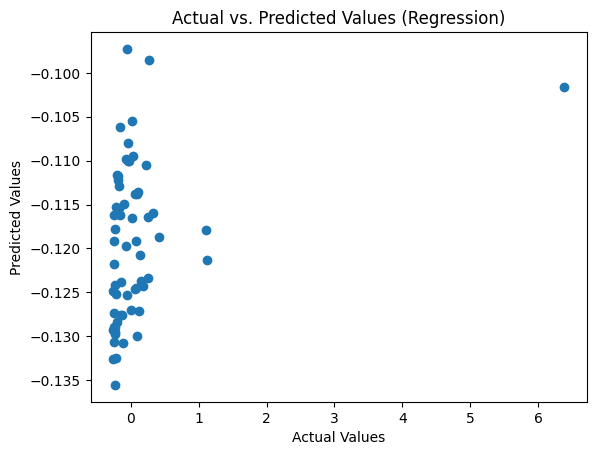

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf

# Load dataset
dataset = pd.read_csv('TASK-ML-INTERN.csv')

# Inspect class distribution
def inspect_class_distribution(labels):
    class_counts = pd.Series(labels).value_counts()
    print("Class Distribution:")
    print(class_counts)
    return class_counts

# Remove classes with fewer than 2 samples
def remove_sparse_classes(data, labels, min_samples=2):
    class_counts = pd.Series(labels).value_counts()
    sparse_classes = class_counts[class_counts < min_samples].index
    
    # Identify indices to keep
    keep_indices = ~pd.Series(labels).isin(sparse_classes)
    
    # Filter data and labels
    filtered_data = data[keep_indices].copy()
    filtered_labels = labels[keep_indices].copy()
    
    print(f"Removed classes: {sparse_classes}")
    return filtered_data, filtered_labels

# Split dataset into training and testing sets
def split_dataset(data, labels, test_size=0.01):  # Reduced test_size to 0.01
    try:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42, stratify=labels)
    except ValueError as e:
        print("Stratified split failed. Performing manual split.")
        
        # Manual Split: ensure each class has at least one sample in test set
        unique_classes = np.unique(labels)
        test_indices = []
        train_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            test_index = cls_indices[0]  # Take the first index for test
            train_indices_cls = cls_indices[1:]  # Remaining indices for training
            
            test_indices.append(test_index)
            train_indices.extend(train_indices_cls)
            
        X_train = data.iloc[train_indices]
        X_test = data.iloc[test_indices]
        y_train = labels[train_indices]
        y_test = labels[test_indices]
        
        print("Manual split complete.")
        return X_train, X_test, y_train, y_test
        
    return X_train, X_test, y_train, y_test

# Reshape data for CNN input
def reshape_data(data):
    reshaped_data = data.reshape(-1, data.shape[1], 1)
    return reshaped_data

# Define CNN model architecture for regression
def create_cnn_model(input_shape, optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation=activation, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])  # Use mean squared error for regression
    return model

# Evaluate the model using regression metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Visualize results
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values (Regression)")
    plt.show()

# Main execution
# Assuming the last column is the target variable for regression
labels = dataset.iloc[:, -1]  # Use the last column as the target variable
data = dataset.iloc[:, :-1]   # Use all columns except the last as features

# Inspect class distribution
inspect_class_distribution(labels)

# Scale the labels
scaler = StandardScaler()
labels = scaler.fit_transform(labels.values.reshape(-1, 1)).flatten()

# Remove sparse classes
data, labels = remove_sparse_classes(data, labels)

# Remove 'hsi_id' column explicitly
data = data.drop('hsi_id', axis=1, errors='ignore')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = split_dataset(data, labels)

# Convert to numpy array before reshaping
X_train = X_train.values
X_test = X_test.values

# Reshape data for CNN input
X_train_reshaped = reshape_data(X_train)
X_test_reshaped = reshape_data(X_test)

# Convert data to float32
X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Determine the input shape
input_shape = (X_train_reshaped.shape[1], 1)

# Create CNN model with fixed hyperparameters
optimizer = 'adam'
activation = 'relu'
dropout_rate = 0.2
model = create_cnn_model(input_shape, optimizer, activation, dropout_rate)

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, verbose=1)

# Evaluate the model
evaluate_model(model, X_test_reshaped, y_test)
